### Narzędzie graficzne

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE =0.09 #0.002

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1: #POPRAWA NARZĘDZIA
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim()[1]- self.ax.get_xlim()[0],
                                                                    self.ax.get_ylim()[1]- self.ax.get_ylim()[0]])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else: 
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()
        
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

## Importowanie wykorzystywanych bibliotek

In [2]:
import random
import math
from sympy.geometry import Point2D, Segment2D, Circle
from scipy.spatial import ConvexHull
from matplotlib.patches import Rectangle

## Generowanie punktów funkcją

In [3]:
def generate_points(n=30, a=-100, b=100):
    """
    Generuje zbiór punktów na płaszczyżnie
    :param n: ilość punktów
    :param a: dolna granica
    :param b: górna granica
    :return: zbiór punktów
    """
    points = [(random.uniform(a, b), random.uniform(a, b)) for _ in range(n)]
    return points

## Wyznaczanie najmniejszego okręgu

In [4]:
def unique_point_set(points):
    """
    Usuwa zdublowane punkty w zbiorze
    :param points: zbiór punktów
    :return: okrojony zbiór punktów
    """
    seen = []
    keep = []
    for point in points:
        if point not in seen:
            seen.append(point)
            keep.append(point)

    return seen, keep

def welzl_algorithm(points, R):
    """
    Wyznacza najmniejsze okalające zbiór koło
    :param points: zbiór punktów w postaci (x, y)
    :param R: pusta lista
    :return: krotka (x, y, promień)
    """

    if not points or len(R) >= 3:
        if len(R) == 1:
            points = R[0]
            circle = [points, 0]
            return circle
        # jeśli points jest puste, to najmniejszy okrąg zawiera w sobie dwa punkty, a środek znajduje się w połowie
        # odcinka między nimi
        elif len(R) == 2:
            center = [(R[0][0] + R[1][0]) / 2, (R[0][1] + R[1][1]) / 2]
            diameter = math.sqrt(math.pow(R[1][0] - R[0][0], 2) + math.pow(R[1][1] - R[0][1], 2))
            circle = (center, diameter / 2)
            return circle
        # jeśli w R są co najmniej trzy punkty, i wszystkie znajdują się na jednym okręgu to liczymy ich środek
        elif len(R) >= 3 and is_cocircular(R):
            p1 = Point2D([R[0][0], R[0][1]])
            p2 = Point2D([R[1][0], R[1][1]])
            p3 = Point2D([R[2][0], R[2][1]])
            center = calculate_circle_center(p1, p2, p3)
            radius = p1.distance(center)
            circle = (center, radius)
            return circle
        else:
            return None
    else:
        # randomowo wybieramy punkt z p
        randomInt = random.randint(0, len(points) - 1)
        p = points[randomInt]
        points.remove(points.__getitem__(randomInt))

        D = welzl_algorithm(points, R)
        if D is not None and p_is_inside_circle(p, D):
            return D
        else:
            R.append(p)
            return welzl_algorithm(points, R)


def p_is_inside_circle(point, circle):
    """
    Sprawdza czy punkt znajduje się w środku okręgu
    :param point: punkt (x, y)
    :param circle: okrąg ((x, y), r)
    :return: tak/nie
    """
    radius = circle[1]
    distance = math.sqrt(math.pow(circle[0][0] - point[0], 2) + math.pow(circle[0][1] - point[1], 2))
    if distance > radius:
        return False
    else:
        return True


def is_cocircular(R):
    """
    Sprawdza czy wszystkie punkty w R znajdują się na tym samym okręgu. By tak było, to ich odległość od środka
    okręgu musi być taka sama
    :param R: zbiór R
    :return: tak/nie
    """
    remember_radius = -99
    for x in range(0, len(R) - 2):
        p1 = Point2D(R[x][0], R[x][1])
        p2 = Point2D(R[x + 1][0], R[x + 1][1])
        p3 = Point2D(R[x + 2][0], R[x + 2][1])
        circle_center = calculate_circle_center(p1, p2, p3)
        if not circle_center:
            return False
        # Sprawdzamy czy wszystkie 3 punkty mają taką samą odległość do środka - jeśli tak to jest to promień
        r1 = p1.distance(circle_center)
        r2 = p2.distance(circle_center)
        r3 = p3.distance(circle_center)
        if r1 == r2 == r3:
            if remember_radius == -99 or remember_radius == r1:
                remember_radius = r1
                continue
            elif remember_radius != r1:
               # nie koło
                return False
        else:
            # nie koło
            return False
    return True


def calculate_circle_center(p1, p2, p3):
    """
    Oblicza środek okręgu, poprzez obliczenie punktu przecięcia prostopadłych dwóch boków
    :param p1: pierwszy punkt (x, y)
    :param p2: drugi punkt (x, y)
    :param p3: trzeci punkt (x, y)
    :return: srodek okręgu (x, y) lub None w przypadku jego braku
    """
    s1 = Segment2D(p1, p2)
    s2 = Segment2D(p2, p3)
    # Wyznaczamy prosteprostopadłe do s1 i s2
    midpoint1 = s1.midpoint
    perp_line1 = s1.perpendicular_line(midpoint1)
    midpoint2 = s2.midpoint
    perp_line2 = s2.perpendicular_line(midpoint2)
    # Wyznaczamy punkt przecięcia, który będzie środkiem okręgu
    circle_center = perp_line1.intersection(perp_line2)
    try:
        circle_center[0]
        return circle_center[0]
    except IndexError:
        # boki równoległe -> brak punkta przecięcia
        return None


def check_all_points_inside(circle, points):
    """
    Za pomocą biblioteki sympy sprawdza czy wszytskie punkty znajdują się w środku okręgu
    :param circle: okrąg ((x, y), r)
    :param points: zbiór punktów
    :return: tak/nie
    """
    c = Circle((circle[0][0], circle[0][1]), circle[1])
    for p in points:
        pp = Point2D(p[0], p[1])
        # Sprawdzamy czy punkt zaiwera się w okręgu
        # enclosed() zwraca Fałsz gdy punkt znajduje się na brzegu okręgu 
        enclosed = c.encloses_point(pp)
        onBorder = c.intersection(pp)
        if not enclosed and not onBorder:
            print("not enclosed")
            return False
    return True


def draw_circle(circle, all_points):
    if circle is not None:
        x = []
        y = []
        for t in all_points:
            x.append(t[0])
            y.append(t[1])
        plt.scatter(x, y, alpha=0.5)
        radius = circle[1]
        circleX = circle[0][0]
        circleY = circle[0][1]
        circle = plt.Circle((circleX, circleY), radius=radius, color='darkmagenta', fill=False)
        plt.gca().add_patch(circle)
        plt.xlim(float(circleX)-float(radius)-1.0, float(circleX)+float(radius)+1.0)
        plt.ylim(float(circleY)-float(radius)-1.0, float(circleY)+float(radius)+1.0)
        plt.show()

        
def min_circle(points):
    seen, keep = unique_point_set(points)
    print(keep)
    circle_found = False
    
    if len(points) == 0:
        return None
    elif len(points) == 1:
        circle = ((points[0][0], points[0][1]), 0)
        print(circle)
        draw_circle(circle, seen)
        return circle
    elif len(points) == 2:
            center = [(points[0][0] + points[1][0]) / 2, (points[0][1] + points[1][1]) / 2]
            diameter = math.sqrt(math.pow(points[1][0] - points[0][0], 2) + math.pow(points[1][1] - points[0][1], 2))
            circle = (center, diameter / 2)
            print(circle)
            draw_circle(circle, seen)
            return circle
        
    while not circle_found:
        points_to_keep = keep.copy()

        boundary_points = []

        circle = welzl_algorithm(points_to_keep, boundary_points)
        all_point_inside = False
        if circle:
            all_point_inside = check_all_points_inside(circle, seen)

        if circle is not None and all_point_inside:
            circle_found = True
            print(circle)
            draw_circle(circle, seen)
            return circle

## Wyznaczanie najmniejszych prostokątów

In [5]:
def generate_points(n=30, a=-100, b=100):
    """
    Generuje zbiór punktów na płaszczyżnie
    :param n: ilość punktów
    :param a: dolna granica
    :param b: górna granica
    :return: zbiór punktów
    """
    points = [(random.uniform(a, b), random.uniform(a, b)) for _ in range(n)]
    return points


def rotating_caliper_all_rectangles(hull_points):
    """
    Wyznacza wszytskie możliwe prostokąty
    :param hull_points: zbiór punktów otoczki wypukłej w postaci (x, y)
    :return: zwraca listę wyznaczonych prostokątów
    """
    # Obliczamy krawędzie
    edges = np.zeros((len(hull_points)-1, 2))
    for i in range(len(edges)):
        edge_x = hull_points[i+1,0] - hull_points[i,0]
        edge_y = hull_points[i+1,1] - hull_points[i,1]
        edges[i] = [edge_x, edge_y]

    # Obliczmy kąty krawędzi za pomocą atan2(y/x) z biblioteki numPy
    edge_angles = np.zeros((len(edges)))
    for i in range(len(edge_angles)):
        edge_angles[i] = np.arctan2(edges[i, 1], edges[i, 0])

    # Sprawdzamy kąty w pierwszej ćwiartce
    for i in range(len(edge_angles)):
        edge_angles[i] = np.abs(edge_angles[i] % (np.pi/2)) # tylko pozytywne wartości !

    # Usuwamy zdublowane punkty
    edge_angles = np.unique(edge_angles)

    bbox_list = []
    for i in range(len(edge_angles)):
        # Tworzymy macierz obrotu
        # R = [ cos(theta)      , cos(theta-PI/2)
        #       cos(theta+PI/2) , cos(theta)     ]
        R = np.array([[np.cos(edge_angles[i]), np.cos(edge_angles[i]-(np.pi/2))],
                      [np.cos(edge_angles[i]+(np.pi/2)), np.cos(edge_angles[i])]])

        # Stosujemy rotacje na wypukłych punktach otoczki
        rot_points = np.dot(R, np.transpose(hull_points)) # 2x2 * 2xn

        # Znajdujemy punkty minimalne i maksymalne
        min_x = np.nanmin(rot_points[0], axis=0)
        max_x = np.nanmax(rot_points[0], axis=0)
        min_y = np.nanmin(rot_points[1], axis=0)
        max_y = np.nanmax(rot_points[1], axis=0)

        # Obliczamy wysokość/szerokość/pole/obwód prostokąta
        width = max_x - min_x
        height = max_y - min_y
        area = width*height
        perimeter = abs(2*width + 2*height)

        # Obliczamy punkt centralny i przywracamy orginalny układ współrzędnych
        center_x = (min_x + max_x)/2
        center_y = (min_y + max_y)/2
        center_point = np.dot([center_x, center_y], R)

        # Obliczamy punkty wierzchołkowe i przywracamy orginalny układ współrzędnych
        corner_points = np.zeros((4, 2))  # empty 2 column array
        corner_points[0] = np.dot([max_x, min_y], R)
        corner_points[1] = np.dot([min_x, min_y], R)
        corner_points[2] = np.dot([min_x, max_y], R)
        corner_points[3] = np.dot([max_x, max_y], R)
        bbox_info = [edge_angles[i], area, perimeter, width, height, min_x, max_x, min_y, max_y, corner_points, center_point]
        bbox_list.append(bbox_info)

    return bbox_list


def find_minimum_area_rectangle(bbox_list):
    """
    Znajduje prostokąt o najmniejszym polu
    :param bbox_list: przyjmuje listę prostokątów do rozważenia
    :return: zwraca prostokąt o najmniejszym polu
    """
    bbox_list.sort(key=lambda x:x[1])
    return bbox_list[0]


def find_minimum_perimeter_rectangle(bbox_list):
    """
    Znajduje prostokąt o najmniejszym obwodzie
    :param bbox_list: przyjmuje liste prostokątów do rozważenia
    :return: zwraca prostokąt o najmniejszym obwodzie
    """
    bbox_list.sort(key=lambda x:x[2])
    return bbox_list[0]


def draw_rectangle(bbox, all_points):
    """
    Odpowiada za rysowanie wyznaczonego prostokąta
    :param bbox: wyznaczony prostokąt
    :param all_points: wszytskie punkty w chmurze
    :return:
    """
    if bbox is not None:
        x = []
        y = []
        for point in all_points:
            x.append(point[0])
            y.append(point[1])
        plt.scatter(x, y, alpha=0.5)
        corner = bbox[9][1]
        width = bbox[0]
        height = bbox[4]
        angle = np.rad2deg(bbox[0])
        rotation_point = (bbox[10][0], bbox[10][1])
        rectangle = plt.Rectangle(xy=corner, width=width, height=height, angle=angle,
                                  fill=False)
        plt.gca().add_patch(rectangle)
        plt.show()

def give_me_rectangle(points, answer_type):
    """
    Odpowiada za główne zarządzanie programem
    :param points: zbiór punktów w postaci (x, y)
    :param answer_type: 0 -> minimalny obwód prostokąta, 1 -> minimalne pole prostokąta
    :return: znaleziony prostokąt prostokąt
    """
    hull = ConvexHull(points)
    hull_points = hull.points
    bbox_list = rotating_caliper_all_rectangles(hull_points)

    if answer_type == 1:
        result = find_minimum_area_rectangle(bbox_list)
    elif answer_type == 0:
        result = find_minimum_perimeter_rectangle(bbox_list)
        
#     draw_rectangle(result, points)
    return result

## Testowanie i wizualizacja

### 1. Okrąg

<IPython.core.display.Javascript object>


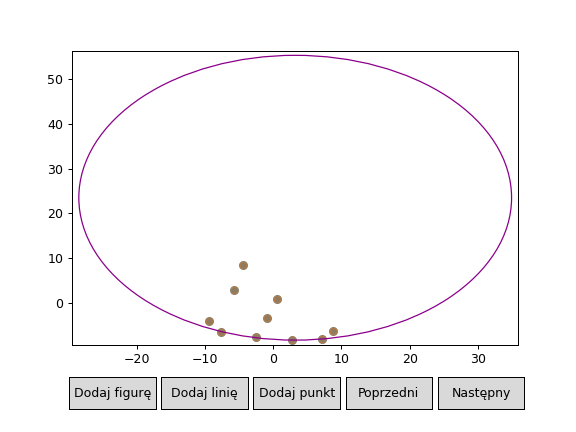

[(0.4913754405528792, 1.0013803965835937), (-9.394590535518045, -3.990309735714261), (-5.722865344651287, 2.875189738921847), (8.798042145862702, -6.2054517635503466), (7.096019386757856, -7.968647382421548), (-4.460534716946604, 8.547842506415389), (-2.5061619955273873, -7.618436739307923), (-7.582603227104179, -6.309390958937904), (-0.9193997822723361, -3.224693106623353), (2.791674700378927, -8.203492544048178)]
[(0.4913754405528792, 1.0013803965835937), (-9.394590535518045, -3.990309735714261), (-5.722865344651287, 2.875189738921847), (8.798042145862702, -6.2054517635503466), (7.096019386757856, -7.968647382421548), (-4.460534716946604, 8.547842506415389), (-2.5061619955273873, -7.618436739307923), (-7.582603227104179, -6.309390958937904), (-0.9193997822723361, -3.224693106623353), (2.791674700378927, -8.203492544048178)]
(Point2D(7578066736106260558789414325208492191340059/2353158904437931872454971026600000000000000, 55304834718488663925761822180654472232789919/2353158904437931872

In [13]:
%matplotlib notebook

set_10 = generate_points(n=10, a=-10, b=10)

scenes=[Scene([PointsCollection(set_10)])]
plot = Plot(scenes).draw()
print(set_10)
min_circle(set_10)

<IPython.core.display.Javascript object>


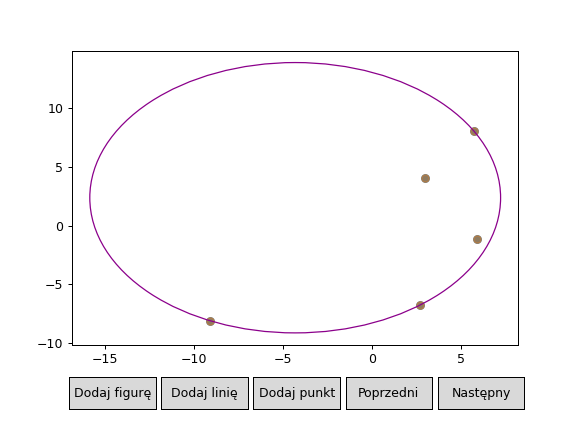

[(2.711543665274368, -6.7782247006978835), (2.989846459823589, 4.080818016021659), (-9.079249551355344, -8.131957672608067), (5.923887090167884, -1.1822268688318722), (5.744370982998959, 8.035264683214798)]
[(2.711543665274368, -6.7782247006978835), (2.989846459823589, 4.080818016021659), (-9.079249551355344, -8.131957672608067), (5.923887090167884, -1.1822268688318722), (5.744370982998959, 8.035264683214798)]
(Point2D(-490375914460247949601322095623052198506603871/113704767869560086669030599433800000000000000, 270286097548379287854457847220184697269228347/113704767869560086669030599433800000000000000), sqrt(1721594222175343939122522744803364326818983396595814055506426485340176697990171344769696410)/113704767869560086669030599433800000000000000)


In [14]:
%matplotlib notebook

set_5 = generate_points(n=5, a=-10, b=10)

scenes=[Scene([PointsCollection(set_5)])]
plot = Plot(scenes).draw()
print(set_5)
min_circle(set_5)

<IPython.core.display.Javascript object>


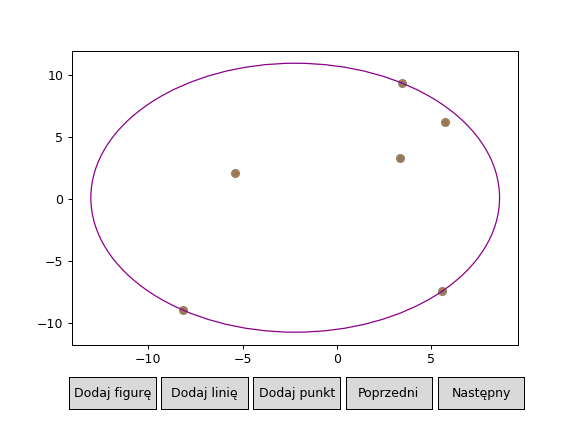

[(3.365590931995566, 3.3003531640492927), (-8.140275087937068, -8.962929334559567), (-5.408063984902616, 2.1043714718533746), (5.733701322435984, 6.221789727848176), (3.444010879158352, 9.370139510170773), (5.596699988728808, -7.412435439736232)]
[(3.365590931995566, 3.3003531640492927), (-8.140275087937068, -8.962929334559567), (-5.408063984902616, 2.1043714718533746), (5.733701322435984, 6.221789727848176), (3.444010879158352, 9.370139510170773), (5.596699988728808, -7.412435439736232)]
not enclosed
(Point2D(-16144919855468414228583429333807134736623409/7308735785343477461556907990512500000000000, 211375393831689601458311491164806310041419/1827183946335869365389226997628125000000000), sqrt(16081881236616034831308540420230555972949527795660458256261036424967925969118189673157810)/11693977256549563938491052784820000000000000)


In [15]:
%matplotlib notebook

set_6 = generate_points(n=6, a=-10, b=10)

scenes=[Scene([PointsCollection(set_6)])]
plot = Plot(scenes).draw()
print(set_6)
min_circle(set_6)

<IPython.core.display.Javascript object>


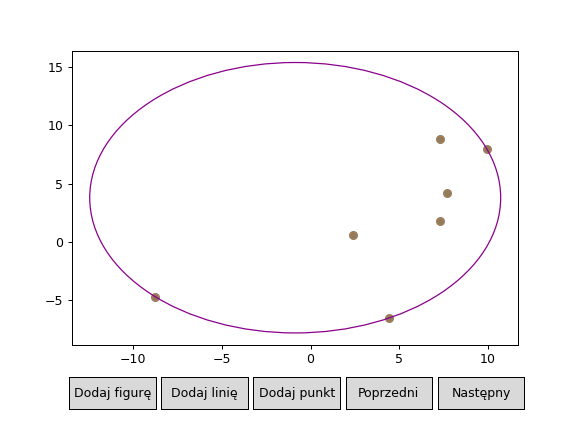

[(7.328884051761229, 8.789323172032624), (9.947608442361087, 7.967966728198434), (7.294774964481945, 1.7549657282065851), (4.447828135597318, -6.511398884339696), (7.671167146585205, 4.1698871655300636), (-8.783365785142273, -4.678624976167203), (2.3744318455784885, 0.5737997829132109)]
[(7.328884051761229, 8.789323172032624), (9.947608442361087, 7.967966728198434), (7.294774964481945, 1.7549657282065851), (4.447828135597318, -6.511398884339696), (7.671167146585205, 4.1698871655300636), (-8.783365785142273, -4.678624976167203), (2.3744318455784885, 0.5737997829132109)]
(Point2D(-69977527885810072032386101464647503936437433/80663659246279184446470634356680000000000000, 1529282325062942578909064330844967521610958239/403318296231395922232353171783400000000000000), 41*sqrt(13006268812164591974874797032118399885753997657194837149624648735119131099573501253444770)/403318296231395922232353171783400000000000000)


In [16]:
%matplotlib notebook

set_7 = generate_points(n=7, a=-10, b=10)

scenes=[Scene([PointsCollection(set_7)])]
plot = Plot(scenes).draw()
print(set_7)
min_circle(set_7)

<IPython.core.display.Javascript object>


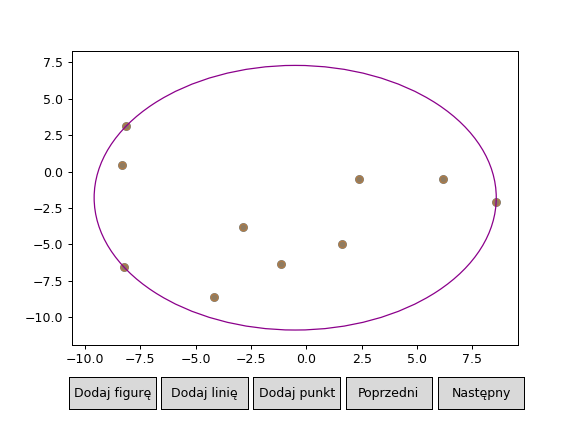

[(-1.1589142733219777, -6.378858355940647), (-8.22241208865697, -6.573483832178657), (2.3618858578893303, -0.5090128454679981), (-4.181141319864237, -8.609896298341956), (-8.122362995224112, 3.1390813849377803), (6.164071127608729, -0.49519945589426584), (8.572841321031827, -2.117940825553408), (-2.843639499102122, -3.8306972539321453), (-8.317550789771193, 0.4702296377470834), (1.6003461282776321, -4.971008233980201)]
[(-1.1589142733219777, -6.378858355940647), (-8.22241208865697, -6.573483832178657), (2.3618858578893303, -0.5090128454679981), (-4.181141319864237, -8.609896298341956), (-8.122362995224112, 3.1390813849377803), (6.164071127608729, -0.49519945589426584), (8.572841321031827, -2.117940825553408), (-2.843639499102122, -3.8306972539321453), (-8.317550789771193, 0.4702296377470834), (1.6003461282776321, -4.971008233980201)]
(Point2D(-8152325303120194935215356569843221454823039/16267922104103575338224770815700000000000000, -58441626062357427952469924584078929442937723/32535844

In [17]:
%matplotlib notebook

set_10 = generate_points(n=10, a=-10, b=10)

scenes=[Scene([PointsCollection(set_10)])]
plot = Plot(scenes).draw()
print(set_10)
min_circle(set_10)

<IPython.core.display.Javascript object>


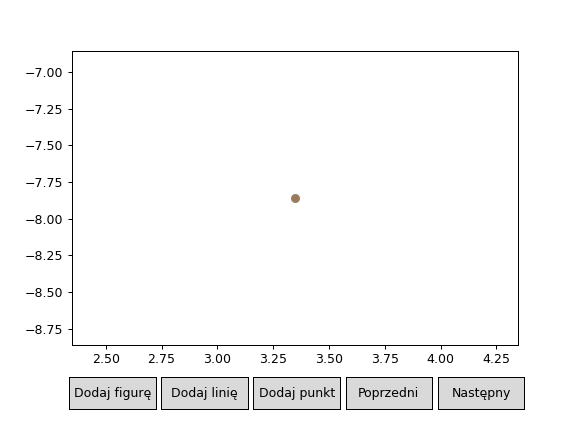

[(3.3486634773595085, -7.857396224507314)]
[(3.3486634773595085, -7.857396224507314)]
((3.3486634773595085, -7.857396224507314), 0)


((3.3486634773595085, -7.857396224507314), 0)

In [55]:
%matplotlib notebook

set_1 = generate_points(n=1, a=-10, b=10)

scenes=[Scene([PointsCollection(set_1)])]
plot = Plot(scenes).draw()
print(set_1)
min_circle(set_1)

<IPython.core.display.Javascript object>


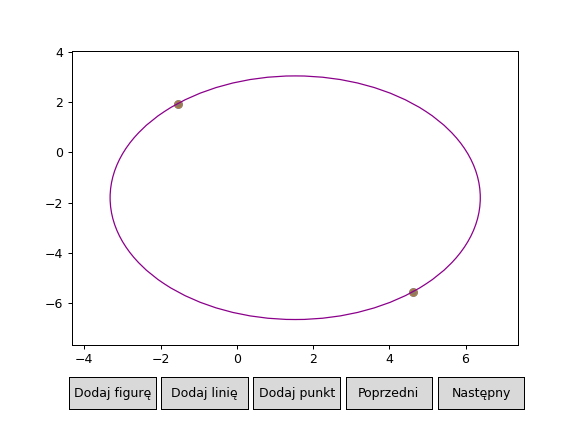

[(-1.5486821919316043, 1.9482327192840199), (4.610903216252677, -5.561218090422361)]
[(-1.5486821919316043, 1.9482327192840199), (4.610903216252677, -5.561218090422361)]
([1.5311105121605362, -1.8064926855691708], 4.856241959172662)


([1.5311105121605362, -1.8064926855691708], 4.856241959172662)

In [60]:
%matplotlib notebook

set_2 = generate_points(n=2, a=-10, b=10)

scenes=[Scene([PointsCollection(set_2)])]
plot = Plot(scenes).draw()
print(set_2)
min_circle(set_2)

<IPython.core.display.Javascript object>


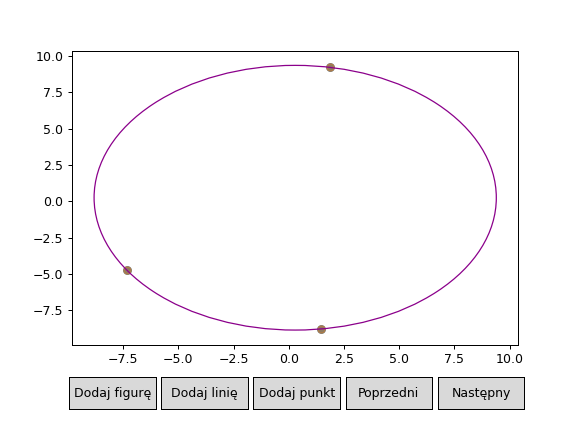

[(-7.332467652905104, -4.7288517097696054), (1.8889732154741274, 9.210316654156827), (1.4786084903452732, -8.781575075189279)]
[(-7.332467652905104, -4.7288517097696054), (1.8889732154741274, 9.210316654156827), (1.4786084903452732, -8.781575075189279)]
(Point2D(31330358076436852343057516009808951698870209/106794015132172602710092562824600000000000000, 26280288096684236445899555050596499780062551/106794015132172602710092562824600000000000000), sqrt(945510241938621349311951364617901500965710059543330478017760211674498046828796081623661410)/106794015132172602710092562824600000000000000)


(Point2D(31330358076436852343057516009808951698870209/106794015132172602710092562824600000000000000, 26280288096684236445899555050596499780062551/106794015132172602710092562824600000000000000),
 sqrt(945510241938621349311951364617901500965710059543330478017760211674498046828796081623661410)/106794015132172602710092562824600000000000000)

In [78]:
%matplotlib notebook

set_3 = generate_points(n=3, a=-10, b=10)

scenes=[Scene([PointsCollection(set_3)])]
plot = Plot(scenes).draw()
print(set_3)
min_circle(set_3)

### 2. Prostokąty

### 2.1 Najmniejszy obwód

<IPython.core.display.Javascript object>


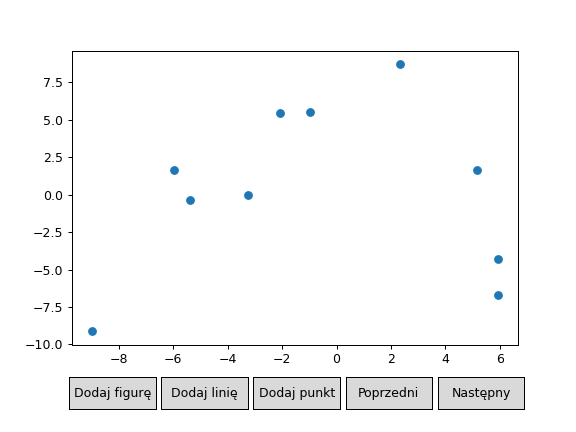

[0.26914200442278013, 260.9947761166687, 64.63590174328472, 16.502065830329126, 15.815885041313235, -11.084006980102846, 5.418058850226282, -8.047727905273996, 7.768157136039239, array([[  7.36293194,  -6.317319  ],
       [ -8.54504955, -10.70529137],
       [-12.75056341,   4.54121226],
       [  3.15741808,   8.92918462]]), array([-2.69381573, -0.88805337])]


In [77]:
%matplotlib notebook

set_2_10 = generate_points(n=10, a=-10, b=10)

scenes=[Scene([PointsCollection(set_2_10)])]
plot = Plot(scenes).draw()

print(give_me_rectangle(set_2_10, 0))

In [21]:
set_2_20 = generate_points(n=20, a=-10, b=10)
print(give_me_rectangle(set_2_20, 0))

[0.05497194540404824, 330.31484618243286, 72.82736881680415, 19.290473537378148, 17.123210871023925, -9.613459210090992, 9.677014327287157, -7.786024305428457, 9.337186565595468, array([[ 10.09019382,  -7.2425665 ],
       [ -9.17113997,  -8.30246735],
       [-10.11196217,   8.7948776 ],
       [  9.14937162,   9.85477845]]), array([-0.01088418,  0.77615555])]


In [79]:
set_2_100 = generate_points(n=100, a=-10, b=10)
print(give_me_rectangle(set_2_100, 0))

[0.08916951561577457, 352.0780731892678, 75.06250242678813, 18.499860256330308, 19.031390957063756, -8.94750463447003, 9.552355621860276, -9.349857373249032, 9.681533583814726, array([[ 10.34702226,  -8.4620601 ],
       [ -8.07933864, -10.10949846],
       [ -9.77411056,   8.84628139],
       [  8.65225035,  10.49371976]]), array([0.28645585, 0.19211065])]


In [25]:
set_2_1000 = generate_points(n=1000, a=-10, b=10)
print(give_me_rectangle(set_2_1000, 0))

[0.0027755745357564976, 398.7809243830643, 79.87826216478075, 20.02078585968335, 19.91834522270703, -10.007849957728295, 10.012935901955057, -9.968016924264635, 9.950328298442393, array([[ 10.04056427,  -9.94018691],
       [ -9.98014447,  -9.99575603],
       [-10.03542925,   9.92251247],
       [  9.98527949,   9.97808158]]), array([ 0.00256751, -0.00883722])]


### 2.2 Najmniejsze pole

In [26]:
print(give_me_rectangle(set_2_10, 1))

[1.1899576211446417, 188.78681377070836, 59.374972906706255, 20.460672922586777, 9.22681353076635, -7.964313997868529, 12.49635892471825, -4.890651592184555, 4.336161938581796, array([[ 9.18513894,  9.78318364],
       [ 1.57992287, -9.21154787],
       [-6.98581914, -5.78194852],
       [ 0.61939692, 13.21278298]]), array([1.0996599 , 2.00061756])]


In [27]:
set_2_20 = generate_points(n=20, a=-10, b=10)
print(give_me_rectangle(set_2_20, 1))

[0.04144320867545259, 307.8659077758857, 70.19230942250911, 17.28518744864507, 17.810967262609488, -8.766622592429503, 8.518564856215566, -9.060993807337965, 8.749973455271524, array([[ 8.88665959, -8.700278  ],
       [-8.38368599, -9.41642659],
       [-9.12161834,  8.37924734],
       [ 8.14872724,  9.09539593]]), array([-0.11747938, -0.16051533])]


In [28]:
set_2_100 = generate_points(n=100, a=-10, b=10)
print(give_me_rectangle(set_2_100, 1))

[0.029556140359149996, 376.9603559823832, 77.66187215509586, 19.408896716973878, 19.422039360574054, -9.586697935294072, 9.822198781679807, -9.768153623256126, 9.653885737317927, array([[ 10.10657581,  -9.47362335],
       [ -9.29384405, -10.04719191],
       [ -9.867801  ,   9.36636486],
       [  9.53261887,   9.93993341]]), array([ 0.11938741, -0.05362925])]


In [30]:
set_2_1000 = generate_points(n=1000, a=-10, b=10)
print(give_me_rectangle(set_2_1000, 1))

[0.0005142402384358233, 398.8819835271241, 79.88812871420848, 19.962768594079108, 19.981295763025134, -9.988045873268229, 9.974722720810878, -9.983001766275526, 9.998293996749608, array([[ 9.97985506, -9.97787104],
       [-9.98291089, -9.9881367 ],
       [-9.99318608,  9.99315642],
       [ 9.96957988, 10.00342208]]), array([-0.00666551,  0.00764269])]


## Sekcje dla użytkownika

### 1.Okrąg

<IPython.core.display.Javascript object>


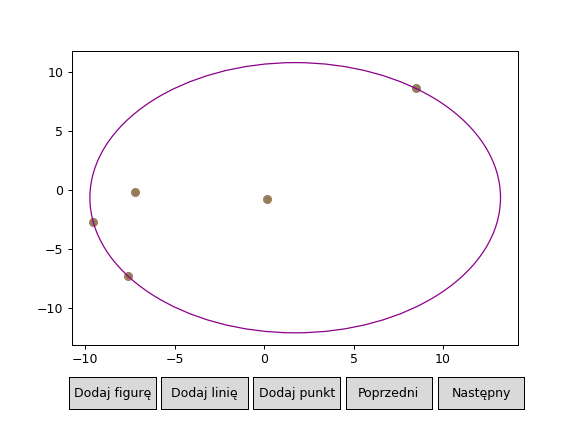

[(-7.5967668397911625, -7.318419427842069), (-9.55491293727681, -2.669598030878852), (-7.205729833299499, -0.1946833086145734), (0.1696955065554988, -0.7343067650356936), (8.480185483497849, 8.635288138906297)]
[(-7.5967668397911625, -7.318419427842069), (-9.55491293727681, -2.669598030878852), (-7.205729833299499, -0.1946833086145734), (0.1696955065554988, -0.7343067650356936), (8.480185483497849, 8.635288138906297)]
(Point2D(368650033668872426629650590970092984804774043/211957140341438213145799272205400000000000000, -137591347025605291177147604353197625243715119/211957140341438213145799272205400000000000000), 13*sqrt(34994488279930490819524129697218793752200025955691773353898712452454668628458113270181170)/211957140341438213145799272205400000000000000)


(Point2D(368650033668872426629650590970092984804774043/211957140341438213145799272205400000000000000, -137591347025605291177147604353197625243715119/211957140341438213145799272205400000000000000),
 13*sqrt(34994488279930490819524129697218793752200025955691773353898712452454668628458113270181170)/211957140341438213145799272205400000000000000)

In [10]:
%matplotlib notebook

user_set_1 = generate_points(n=5, a=-10, b=10)

scenes=[Scene([PointsCollection(user_set_1)])]
plot = Plot(scenes).draw()
print(user_set_1)
min_circle(user_set_1)

<IPython.core.display.Javascript object>


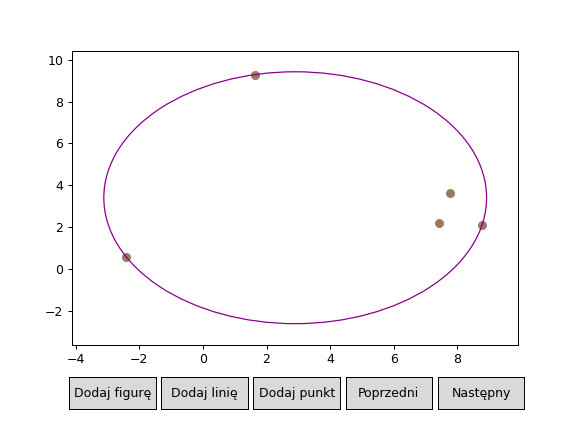

[(-2.4063548277212776, 0.5765198250958328), (7.779158251232296, 3.6352510907431608), (7.428762091987501, 2.1939319413453937), (8.777402937242599, 2.11849600527486), (1.6319667565124298, 9.285804985183535)]
[(-2.4063548277212776, 0.5765198250958328), (7.779158251232296, 3.6352510907431608), (7.428762091987501, 2.1939319413453937), (8.777402937242599, 2.11849600527486), (1.6319667565124298, 9.285804985183535)]
(Point2D(8818748359479527648566431420385274729193552053/3039184661520812296367469287433000000000000000, 6901332169066367163882161930163306330238954943/2026123107680541530911646191622000000000000000), sqrt(1336808797879912259459306159367084534413952357521970459533137283011553341828780300006252652797)/6078369323041624592734938574866000000000000000)


(Point2D(8818748359479527648566431420385274729193552053/3039184661520812296367469287433000000000000000, 6901332169066367163882161930163306330238954943/2026123107680541530911646191622000000000000000),
 sqrt(1336808797879912259459306159367084534413952357521970459533137283011553341828780300006252652797)/6078369323041624592734938574866000000000000000)

In [11]:
%matplotlib notebook

user_set_2 = generate_points(n=5, a=-10, b=10)

scenes=[Scene([PointsCollection(user_set_2)])]
plot = Plot(scenes).draw()
print(user_set_2)
min_circle(user_set_2)

### 2. Prostokąty

### 2.1 Obwód

In [6]:
user_set_2_1_1 = generate_points(n=10, a=-10, b=10)
print(give_me_rectangle(user_set_2_1_1, 0))

[0.2564831127118661, 308.42540487771464, 70.2628399746231, 17.206874789831296, 17.924545197480256, -10.313151404503454, 6.893723385327842, -7.549434508318226, 10.37511068916203, array([[  8.58335945,  -5.55367663],
       [ -8.06064617,  -9.91872152],
       [-12.6077499 ,   7.41947817],
       [  4.03625572,  11.78452306]]), array([-2.01219522,  0.93290077])]


In [7]:
user_set_2_1_2 = generate_points(n=10, a=-10, b=10)
print(give_me_rectangle(user_set_2_1_2, 0))

[0.7735183956244205, 262.3681463105658, 65.7292380496583, 13.665967234021537, 19.198651790807617, -5.4079587304267545, 8.258008503594782, -6.723532838888667, 12.47511895191895, array([[ 10.60569165,   0.95911564],
       [  0.82828039,  -8.58870555],
       [-12.58498859,   5.14710334],
       [ -2.80757732,  14.69492453]]), array([-0.98964847,  3.05310949])]


### 2.2 Pole

In [8]:
user_set_2_2_1 = generate_points(n=10, a=-10, b=10)
print(give_me_rectangle(user_set_2_2_1, 1))

[1.2634534452252564, 187.51559937146857, 57.23656867792589, 10.157521973104595, 18.46076236585835, -5.519469248012417, 4.638052725092178, -10.607767045226293, 7.852995320632056, array([[11.51383204,  1.21158021],
       [ 8.44090638, -8.46996824],
       [-9.15479914, -2.88508735],
       [-6.08187348,  6.79646111]]), array([ 1.17951645, -0.83675357])]


In [9]:
user_set_2_2_2 = generate_points(n=10, a=-10, b=10)
print(give_me_rectangle(user_set_2_2_2, 1))

[0.8034219292305335, 179.75550153368948, 56.30358693878617, 9.78924683621506, 18.362546633178024, -2.0007913263983332, 7.7884555098167265, -9.532115305862476, 8.830431327315548, array([[12.26772506, -1.01201941],
       [ 5.47156107, -8.05769245],
       [-7.7446242 ,  4.69046687],
       [-0.9484602 , 11.73613991]]), array([2.26155043, 1.83922373])]
